# From Expressions to Machine Learning

Copyright Luca de Alfaro, 2019-21.
License: [CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/4.0/).



Prepared on: Thu Oct 28 11:35:32 2021

This is a book chapter; it is not a homework assignment.  
Do not submit it as a solution to a homework assignment; you would receive no credit.


## ML in a nutshell

Optimization, and machine learning, are intimately connected.  At a very coarse level, ML works as follows. 

First, you come up somehow with a very complicated model $\hat{y} = M(x, \theta)$, which computes an output $\hat{y}$ as a function of an input $x$ and of a vector of parameters $\theta$.   In general, $x$, $y$, and $\theta$ are vectors, as the model has multiple inputs, multiple outputs, and several parameters.  The model $M$ needs to be complicated, because only complicated models can represent complicated phenomena; for instance, $M$ can be a multi-layer neural net with parameters $\theta = [\theta_1, \ldots, \theta_k]$, where $k$ is the number of parameters of the model. 

Second, you come up with a notion of _loss_ $L$, that is, how badly the model is doing.  For instance, if you have a list of inputs $x_1, \ldots, x_n$, and a set of desired outputs $y_1, \ldots, y_m$, you can use as loss: 

$$
L(\theta) = \sum_{i=1}^n |\!|y_i - \hat{y}_i |\!| = \sum_{i=1}^n |\!| y_i - M({x}_i, \theta)|\!| \; .
$$

Here, we wrote $L(\theta)$ because, once the inputs $x_1, \ldots, x_n$ and the desired outputs $y_1, \ldots, y_n$ are chosen, the loss $L$ depends only on $\theta$. 

Once the loss is chosen, you decrease it, by computing its _gradient_ with respect to ${\theta}$.  Remembering that ${\theta} = [\theta_1, \ldots, \theta_k]$,

$$
\nabla_{\theta} L = \left[ \frac{\partial L}{\partial \theta_1}, \ldots, 
    \frac{\partial L}{\partial \theta_k} \right] \; .
$$

The gradient is a vector that indicates how to tweak ${\theta}$ to decrease the loss.  You then choose a small _step size_ $\delta$, and you update ${\theta}$ via ${\theta} := {\theta} - \delta \nabla_{\theta} L$.  This makes the loss a little bit smaller, and the model a little bit better.  If you repeat this step many times, the model will hopefully get (a good bit) better. 

## Autogradient

The key to _pleasant_ ML is to focus on building the model $M$ in a way that is sufficiently expressive, and on choosing a loss $L$ that is helpful in guiding the optimization.  The computation of the gradient is done automatically for you.  This capability, called _autogradient_, is implemented in ML frameworks such as [Tensorflow](https://www.tensorflow.com), [Keras](https://keras.io), and [PyTorch](https://pytorch.org).  

It is possible to use these advanced ML libraries without ever knowing what is under the hood, and how autogradient works.  Here, we will insted dive in, and implement autogradient.  

Building a model $M$ corresponds to building an expression with inputs ${x}$, ${\theta}$.  We will provide a representaton for expressions that enables both the calculation of the expression value, and the differentiation with respect to any of the inputs.  This will enable us to implement autogradient.  On the basis of this, we will be able to implement a simple ML framework. 

We say we, but we mean you.  _You_ will implement it; we will just provide guidance.

## Overview

Let us give you a preview of how our ML framework works with an example. 

Assume for simplicity that our ML problem has only one input $x$, and one output $y$.  We are given many pairs $x_1, y_1, \ldots, x_n, y_n$ of training input/output pairs, and we want to approximate the input-output relation via a parabola, whose coefficient we need to determine.  In particular, the predicted $\hat{y}$ is given by: 

$$
\hat{y} = a x^2 + bx + c
$$

and the coefficients of the model $M$ are ${\theta} = [a, b, c]$.  We build our model $M$ as an expression giving $\hat{y}$ as an expression with variables $x, a, b, c$.  We write: 

    x = V()
    a = V()
    b = V()
    c = V()

    oy = a * x * x + b * x + c

where `oy` is our _predicted_ output $\hat{y}$.  We can then compute the loss, for instance using the quadratic distance of the output to the true $y$: 

    y = V() 
    loss = (y - oy) * (y - oy)

In the code above, `oy` and `loss` are objects of class `Expr`.  If we have a particular input $x_0$, and desired output $y_0$, where both $x_0$ and $y_0$ are numbers, we can do: 

    x.assign(x0)
    y.assign(v0)
    loss.eval()

and obtain the loss.  Then, we can backpropagate the gradient of the loss to the model variables, that is, compute $\partial L / \partial a$, $\partial L / \partial b$, $\partial L / \partial c$, via: 

    loss.zero_gradient()
    loss.compute_gradient()

We can then find the gradient $\partial L / \partial a$ in `a.gradient`, and similarly for the other variables. 
We can update the value of `a` simply via: 

    a.assign(a.eval() - delta * a.gradient)

where `delta` is the learning step. To make all this work, what we need to do is endow our expressions with the methods for gradient propagation, namely, `zero_gradient` and `compute_gradient`. 
We will guide you through this. 


## Our Expression Class

We repeat here our definition of the `Expr` class from the last chapter. 


In [ ]:
class Expr(object):
    """Abstract class representing expressions"""

    def __init__(self, *args):
        """An object is created by passing to the constructor the children"""
        self.children = args
        self.value = None # The value of the expression
        self.child_values = None # The values of the children; useful to have
        self.gradient = None # This is where we will accummulate the gradient.

    def eval(self):
        """Evaluates the expression."""
        # First, we evaluate the children.
        self.child_values = [c.eval() if isinstance(c, Expr) else c
                             for c in self.children]
        # Then, we evaluate the expression itself.
        self.value = self.op(*self.child_values)
        return self.value

    def op(self):
        """This operator must be implemented in subclasses; it should
        compute self.value from self.values, thus implementing the
        operator at the expression node."""
        raise NotImplementedError()

    def __repr__(self):
        """Represents the expression as the name of the class, followed by the
        children, and teh value."""
        return "{}({})".format(self.__class__.__name__,
                                  ', '.join(repr(c) for c in self.children))

    # Expression constructors

    def __add__(self, other):
        return Plus(self, other)

    def __radd__(self, other):
        return Plus(self, other)

    def __sub__(self, other):
        return Minus(self, other)

    def __rsub__(self, other):
        return Minus(other, self)

    def __mul__(self, other):
        return Multiply(self, other)

    def __rmul__(self, other):
        return Multiply(other, self)

    def __truediv__(self, other):
        return Divide(self, other)

    def __rtruediv__(self, other):
        return Divide(other, self)

    def __neg__(self):
        return Negative(self)


In [ ]:
import random
import string

class V(Expr):
    """Variable."""

    def __init__(self, value=None):
        super().__init__()
        self.children = []
        self.value = random.gauss(0, 1) if value is None else value
        self.name = ''.join(
            random.choices(string.ascii_letters + string.digits, k=8))

    def eval(self):
        return self.value

    def assign(self, value):
        self.value = value

    def __repr__(self):
        return "V(name={}, value={})".format(self.name, self.value)


In [ ]:
class Plus(Expr):
    def op(self, x, y):
        return x + y

class Minus(Expr):
    def op(self, x, y):
        return x - y

class Multiply(Expr):
    def op(self, x, y):
        return x * y

class Divide(Expr):
    def op(self, x, y):
        return x / y

class Negative(Expr):
    def op(self, x):
        return -x


In [ ]:
vx = V(value=3)
vy = V(value=2)
e = vx - vy
assert e.eval() == 1.


## Implementing autogradient

The next step consists in implementing autogradient.  Consider an expression $e = E(x_0, \ldots, x_n)$, computed as function of its children expressions $x_0, \ldots, x_n$.  

The goal of the autogradient computation is to accumulate, in each node of the expression, the gradient of the loss with respect to the node's value.  For instance, if the gradient is $2$, we know that if we increase the value of the expression by $\Delta$, then the value of the loss is increased by $2 \Delta$. We accumulate the gradient in the field `self.gradient` of the expression. 

We say _accumulate_ the gradient, because we don't really do:

    self.gradient = ...

Rather, we have a method `e.zero_gradient()` that sets all gradients to 0, and we then _add_ the gradient to this initial value of 0: 

    self.gradient += ... 

We will explain later in detail why we do so; for the moment, just accept it. 

### Computaton of the gradient

In the computation of the autogradient, the expression will receive as input the value $\partial L / \partial e$, where $L$ is the loss, and $e$ the value of the expression.  The quantity $\partial L / \partial e$ is the gradient of the loss with respect to the expression value. 

With this input, the method `compute_gradient` of an Expr $e$ must do the following:

* It must _add_ $\partial L / \partial e$ to the gradient `self.gradient` of the expression. 
* It must call the method `operator_gradient`.  If the expression node has children $c_1, \ldots, c_n$, the method `operator_gradient` must return the list of derivatives of $e$ with respect to its children $x_1, \ldots, x_n$:

  $$
  \left[ \frac{\partial e}{\partial x_1}, \ldots, 
    \frac{\partial e}{\partial x_n} \right]
  $$

  The method `operator_gradient` is implemented not directly in the class `Expr`, but for each specific operator, such as `Plus`, `Multiply`, etc: each operator knows how to compute the partial derivative of its output with respect to its children (its arguments).
* It must propagate to each child $x_i$ the gradient 

  $$
  \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial x_i} \; , 
  $$

  by calling the method `compute_gradient` of the child with argument $\frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial x_i}$. 

In [ ]:
def expr_operator_gradient(self):
    """This method computes the derivative of the operator at the expression
    node.  It needs to be implemented in derived classes, such as Plus,
    Multiply, etc."""
    raise NotImplementedError()

Expr.operator_gradient = expr_operator_gradient

def expr_zero_gradient(self):
    """Sets the gradient to 0, recursively for this expression
    and all its children."""
    self.gradient = 0
    for e in self.children:
        if isinstance(e, Expr):
            e.zero_gradient()

Expr.zero_gradient = expr_zero_gradient

def expr_compute_gradient(self, de_loss_over_de_e=1):
    """Computes the gradient.
    de_loss_over_de_e is the gradient of the output.
    de_loss_over_de_e will be added to the gradient, and then
    we call for each child the method compute_gradient,
    with argument de_loss_over_de_e * d expression / d child.
    The value d expression / d child is computed by self.derivate. """
    pass # We will write this later.

Expr.compute_gradient = expr_compute_gradient


Let us endow our classes `Plus` and `Multiply` with the `operator_gradient` method, so you can see how it works in practice.

In [ ]:
def plus_operator_gradient(self):
    # If e = x + y, de / dx = 1, and de / dy = 1
    return 1, 1

Plus.operator_gradient = plus_operator_gradient

def multiply_operator_gradient(self):
    # If e = x * y, de / dx = y, and de / dy = x
    x, y = self.child_values
    return y, x

Multiply.operator_gradient = multiply_operator_gradient

def variable_operator_gradient(self):
    # This is not really used, but it needs to be here for completeness.
    return None

V.operator_gradient = variable_operator_gradient


Let us comment on some subtle points, before you get to work at implementing `compute_gradient`.  

**`zero_gradient`:** First, notice how in the implementation of `zero_gradient`, when we loop over the children, we check whether each children is an `Expr` via isinstance(e, Expr).  In general, we have to remember that children can be either `Expr`, or simply numbers, and of course numbers do not have methods such as `zero_gradient` or `compute_gradient` implemented for them. 

**`operator_gradient`:** Second, notice how `operator_gradient` is not implemented in `Expr` directly, but rather, only in the derived classes such as `Plus`.  The derivative of the expression with respect to its arguments depends on which function it is, obviously.  

For `Plus`, we have $e = x_0 + x_1$, and so: 

$$
\frac{\partial e}{\partial x_0} = 1 \qquad \frac{\partial e}{\partial x_1} = 1 \; ,
$$

because $d(x+y)/dx = 1$.  Hence, the `operator_gradient` method of `Plus` returns

$$
\left[ \frac{\partial e}{\partial x_0}, \: \frac{\partial e}{\partial x_1}\right] \; = \; [1, 1] \; .
$$

For `Multiply`, we have $e = x_0 \cdot x_1$, and so:

$$
\frac{\partial e}{\partial x_0} = x_1 \qquad \frac{\partial e}{\partial x_1} = x_0 \; ,
$$

because $d(xy)/dx = y$.  Hence, the `operator_gradient` method of `Plus` returns

$$
\left[ \frac{\partial e}{\partial x_0}, \: \frac{\partial e}{\partial x_1}\right] \; = \; [x_1, x_0] \; .
$$


**Calling `compute` before `compute_gradient`:** Lastly, a very important point: when calling `compute_gradient`, we will assume that `eval` has _already_ been called.  In this way, the value of the expression, and its children, are available for the computation of the gradient.  Note how in `Multiply.compute_gradient` we use these values in order to compute the partial derivatives. 

With these clarifications, we ask you to implement the `compute_gradient` method, which again must:

* _add_ $\partial L / \partial e$ to the gradient `self.gradient` of the expression; 
* compute $\frac{\partial e}{\partial x_i}$ by calling the method `operator_gradient` of itself; 
* propagate to each child $x_i$ the gradient $\frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial x_i}$, by calling the method `compute_gradient` of the child $i$ with argument $\frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial x_i}$.

In [ ]:
### Exercise: Implementation of `compute_gradient`

def expr_compute_gradient(self, de_loss_over_de_e=1):
    """Computes the gradient.
    de_loss_over_de_e is the gradient of the output.
    de_loss_over_de_e will be added to the gradient, and then
    we call for each child the method compute_gradient,
    with argument de_loss_over_de_e * d expression / d child.
    The value d expression / d child is computed by self.compute_gradient. """
    ### BEGIN SOLUTION
    raise NotImplementedError()
    ### END SOLUTION

Expr.compute_gradient = expr_compute_gradient


Below are some tests.

In [ ]:
## Tests for `compute_gradient`

# First, the gradient of a sum.
vx = V(value=3)
vz = V(value=4)
y = vx + vz
assert y.eval() == 7
y.zero_gradient()
y.compute_gradient()
assert vx.gradient == 1

# Second, the gradient of a product.
vx = V(value=3)
vz = V(value=4)
y = vx * vz
assert y.eval() == 12
y.zero_gradient()
y.compute_gradient()
assert vx.gradient == 4
assert vz.gradient == 3

# Finally, the gradient of the product of sums.

vx = V(value=1)
vw = V(value=3)
vz = V(value=4)
y = (vx + vw) * (vz + 3)
assert y.eval() == 28
y.zero_gradient()
y.compute_gradient()
assert vx.gradient == 7
assert vz.gradient == 4



In [ ]:
### Hidden tests for compute gradient



## Why do we accumulate gradients?

We are now in the position of answering the question of why we accumulate gradients.  There are two reasons. 

### Multiple variable occurrence

The most important reason why we need to _add_ to the gradient of each node is that nodes, and in particular, variable nodes, can occur in multiple places in an expression tree.  To compute the total influence of the variable on the expression, we need to _sum_ the influence of each occurrence.  Let's see this with a simple example.  Consider the expression $y = x \cdot x$.  We can code it as follows: 


In [ ]:
vx = V(2.) # Creates a variable vx and initializes it to 2.
y = vx * vx


For $y = x^2$, we have $dy / dx = 2x = 4$, given that $x=2$.  How is this reflected in our code? 

Our code considers separately the left and right occurrences of `vx` in the expression; let us denote them with $vx_l$ and $vx_r$.  The expression can be written as $y = vx_l \cdot vx_r$, and we have that $\partial y / \partial \, vx_l = vx_r = 2$, as $vx_r = 2$.  Similarly, $\partial y / \partial \, vx_r = 2$.  These two gradients are added to `vx.gradient` by the method `compute_gradient`, and we get that the total gradient is 4, as desired.

In [ ]:
y.eval() # We have to call eval() before compute_gradient()
y.zero_gradient()
y.compute_gradient()
print("gradient of vx:", vx.gradient)
assert vx.gradient == 4


gradient of vx: 4.0


### Multiple data to fit

The other reason why we need to tally up the gradient is that in general, we need to fit a function to more than one data point.  Assume that we are given a set of inputs $x_1, x_2, \ldots, x_n$ and desired outputs $y_1, y_2, \ldots, y_n$. Our goal is to approximate the desired ouputs via an expression 

$$
y = e(x, \theta)
$$

of the input, according to some parameters $\theta$.  Our goal is to choose the parameters $\theta$ to minimize the sum of the square errors for the points: 

$$
L_{tot}(\theta)
= \sum_{i=1}^n L_i(\theta) 
= \sum_{i=1}^n (e(x_i, \theta) - y_i)^2 
\; ,
$$

where $L_i(\theta) = (e(x_i, \theta) - y_i)^2$ is the loss for a single data point.  The gradient $L_{tot}(\theta)$ with respect to $\theta$ can be computed by adding up the gradients for the individual points:

$$
\frac{\partial}{\partial \theta} L_{tot}(\theta) \;=\;
\sum_{i=1}^n \frac{\partial}{\partial \theta} L_i(\theta) \; .
$$

To translate this into code, we will build an expression $e(x, \theta)$ involving the input $x$ and the parameters $\theta$, and an expression 

$$
L = (e(x, \theta) - y)^2
$$

for the loss, involving $x, y$ and $\theta$.  We will then zero all gradients via `zero_gradient`. Once this is done, we compute the loss $L$ for each point $(x_i, y_i)$, and then the gradient $\partial L / \partial \theta$ via a call to `compute_gradient`.  
The gradients for all the points will be added, yielding the gradient for minimizing the total loss over all the points. 

## Rounding up the implementation

Now that we have implemented autogradient, as well as the operators `Plus` and `Multiply`, it is time to implement the remaining operators: 

* `Minus`
* `Divide` (no need to worry about division by zero)
* and the unary minus `Negative`. 

In [ ]:
### Exercise: Implementation of `Minus`, `Divide`, and `Negative`

def minus_operator_gradient(self):
    # If e = x - y, de / dx = ..., and de / dy = ...
    ### BEGIN SOLUTION
    raise NotImplementedError()
    ### END SOLUTION

Minus.operator_gradient = minus_operator_gradient

def divide_operator_gradient(self):
    # If e = x / y, de / dx = ..., and de / dy = ...
    ### BEGIN SOLUTION
    raise NotImplementedError()
    ### END SOLUTION

Divide.operator_gradient = divide_operator_gradient

def negative_operator_gradient(self):
    # If e = -x, de / dx = ...
    ### BEGIN SOLUTION
    raise NotImplementedError()
    ### END SOLUTION

Negative.operator_gradient = negative_operator_gradient


Here are some tests.

In [ ]:
### Tests for `Minus`

# Minus.
vx = V(value=3)
vy = V(value=2)
e = vx - vy
assert e.eval() == 1.
e.zero_gradient()
e.compute_gradient()
assert vx.gradient == 1
assert vy.gradient == -1



In [ ]:
### Hidden tests for Minus



In [ ]:
# Tests for `Divide`

# Divide.
vx = V(6)
vy = V(2)
e = vx / vy
assert e.eval() == 3
e.zero_gradient()
e.compute_gradient()
assert vx.gradient == 0.5
assert vy.gradient == -1.5



In [ ]:
### Hidden tests for Divide



In [ ]:
## Tests for `Negative`

# Negative
vx = V(6)
e = - vx
assert e.eval() == -6
e.zero_gradient()
e.compute_gradient()
assert vx.gradient == -1



In [ ]:
### Hidden tests for Negative



## Optimization

Let us use our ML framework to fit a parabola to a given set of points.  Here is our set of points:

In [ ]:
points = [
    (-2, 2.7),
    (-1, 3),
    (0, 1.3),
    (1, 2.4),
    (3, 5.5),
    (4, 6.2),
    (5, 9.1),
]


Let us display these points.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (8.0, 3.)
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
matplotlib.rcParams.update(params)

def plot_points(points):
    fig, ax = plt.subplots()
    xs, ys = zip(*points)
    ax.plot(xs, ys, 'r+')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


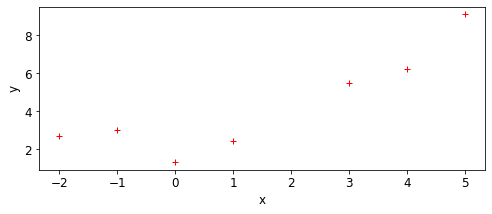

In [ ]:
plot_points(points)


To fit a parabola to these points, we will build an `Expr` that represents the equation $\hat{y} = ax^2 + bx + c$, where $\hat{y}$ is the value of $y$ predicted by our parabola. 
If $\hat{y}$ is the predicted value, and $y$ is the observed value, to obtain a better prediction of the observations, we minimize the loss $L = (\hat{y} - y)^2$, that is, the square prediction error. 
Written out in detail, our loss is:

$$
    L \;=\; \left( y - \hat{y}\right)^ 2 \;=\; \left( y - (ax^2 + bx + c) \right)^2 \; .
$$

Here, $a, b, c$ are parameters that we need to tune to minimize the loss, and obtain a good fit between the parabola and the points. 
This tuning, or training, is done by repeating the following process many times:

* Zero the gradient
* For each point:
    * Set the values of x, y to the value of the point.
    * Compute the expression giving the loss.
    * Backpropagate.  This computes all gradients with respect to the loss, and in particular, the gradients of the coefficients $a, b, c$. 
* Update the coefficients $a, b, c$ by taking a small step in the direction of the negative gradient (negative, so that the loss decreases).

In [ ]:
va = V(value=0.)
vb = V(value=0.)
vc = V(value=0.)
vx = V(value=0.)
vy = V(value=0.)

oy = va * vx * vx + vb * vx + vc

loss = (vy - oy) * (vy - oy)


## Implementing learning: the `fit` function.

The `fit` function minimizes the loss of fitting a series of $(x, y)$ points with a function.  Precisely, the `fit` function takes as input: 

* An expression `loss`, which gives the loss as a function of the values of two variables, `vx` and `vy`, as well as a list of parameters `params`.  In the above example, `params = [va, vb, vc]`. 
* A list `points` of $(x, y)$-pairs, such as `[(2, 3), (3.2, 4.1)]`. 
* A list `params` of parameters to be optimized.  In the above example, `params = [va, vb, vc]`. 
* A learning-step size `delta`. 
* A number of iterations `num_iterations`.

Below, implement the "for each point" part of the above informal description.  Hint: this takes about 4-5 lines of code.  As a reminder, these are the operations you need to use: 

* For a variable `v`, you can assign it a value `x` by saying `v.assign(x)`.  If you want to assign it a `4`, you do `v.assign(4)`, and so forth (look also at the example at line 13). 
* Forward propagation: for the loss `loss`, you can compute its value via `loss.compute()`. 
* Backward propagation: for the loss `loss`, you can perform gradient backpropagation via `loss.compute_gradient()`. 

In [ ]:
def fit(loss, points, params, delta=0.0001, num_iterations=4000):
    """
    @param loss: expression giving the loss as a function of variables and parameters.
    @param points: list of (x, y) values to which we have to fit the expression.
    @param params: list of parameters whose value we can tune.
    @param delta: learning step size.
    @param num_iterations: number of learning iterations.
    """

    for iteration_idx in range(num_iterations):
        loss.zero_gradient()
        total_loss = 0.
        for x, y in points:
            ### You need to implement here the computaton of the
            ### loss gradient for the point (x, y).
            total_loss += loss.value
        if (iteration_idx + 1) % 100 == 0:
            print("Loss:", total_loss)
        for vv in params:
            vv.assign(vv.value - delta * vv.gradient)
    return total_loss


In [ ]:
### Exercise: Implementation of `fit`

def fit(loss, points, params, delta=0.0001, num_iterations=4000):
    """
    @param loss: expression giving the loss as a function of variables and parameters.
    @param points: list of (x, y) values to which we have to fit the expression.
    @param params: list of parameters whose value we can tune.
    @param delta: learning step size.
    @param num_iterations: number of learning iterations.
    """

    for iteration_idx in range(num_iterations):
        loss.zero_gradient()
        total_loss = 0.
        for x, y in points:
            ### BEGIN SOLUTION
            raise NotImplementedError()
            ### END SOLUTION
            total_loss += loss.value
        if (iteration_idx + 1) % 100 == 0:
            print("Loss:", total_loss)
        for vv in params:
            vv.assign(vv.value - delta * vv.gradient)
    return total_loss


Let's train the coefficients `va`, `vb`, `vc`: 

In [ ]:
lv = fit(loss, points, [va, vb, vc])
assert lv < 2.5


Loss: 15.691480263172831
Loss: 13.628854145973717
Loss: 11.95710461470721
Loss: 10.577288435238483
Loss: 9.421709915417068
Loss: 8.442894724380599
Loss: 7.606627717852742
Loss: 6.887533665385938
Loss: 6.266252079473012
Loss: 5.727613949776414
Loss: 5.259450432876111
Loss: 4.851802101057622
Loss: 4.4963837663728965
Loss: 4.18621382152429
Loss: 3.9153507183966223
Loss: 3.6787002636071753
Loss: 3.471870598609928
Loss: 3.2910600093895632
Loss: 3.13296792199636
Loss: 2.9947227347465053
Loss: 2.8738222326925422
Loss: 2.768083672161589
Loss: 2.6756014919475786
Loss: 2.594711177586694
Loss: 2.523958185206276
Loss: 2.462071090153853
Loss: 2.4079383059994615
Loss: 2.360587848696134
Loss: 2.3191697158813342
Loss: 2.28294052348259
Loss: 2.251250098021605
Loss: 2.2235297678961032
Loss: 2.199282133501638
Loss: 2.1780721263873506
Loss: 2.1595191931327227
Loss: 2.1432904612844434
Loss: 2.1290947632296184
Loss: 2.1166774098449848
Loss: 2.105815619569577
Loss: 2.096314520528721


Let's display the parameter values after the training:

In [ ]:
print("a:", va.value, "b:", vb.value, "c:", vc.value)


a: 0.2676799989525098 b: 0.09448237346204012 c: 1.9726742011455856


Let's display the points, along with the fitted parabola.

In [ ]:
import numpy as np

def plot_points_and_y(points, vx, oy):
    fig, ax = plt.subplots()
    xs, ys = zip(*points)
    ax.plot(xs, ys, 'r+')
    x_min, x_max = np.min(xs), np.max(xs)
    step = (x_max - x_min) / 100
    x_list = list(np.arange(x_min, x_max + step, step))
    y_list = []
    for x in x_list:
        vx.assign(x)
        oy.eval()
        y_list.append(oy.value)
    ax.plot(x_list, y_list)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


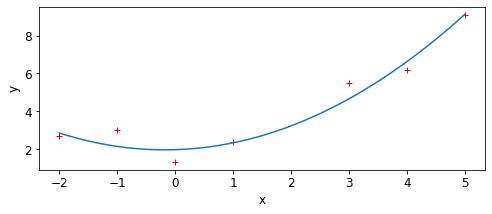

In [ ]:
plot_points_and_y(points, vx, oy)


This looks like a good fit!

Note that if we chose too large a learning step, we would not converge to a solution.  A large step causes the parameter values to zoom all over the place, possibly missing by large amounts the (local) minima where you want to converge.  In the limit where the step size goes to 0, and the number of steps to infinity, you are guaranteed (if the function is differentiable, and some other hypotheses) converge to the minimum; the problem is that it would take infinitely long.  You will learn in a more in-depth ML class how to tune the step size.

In [ ]:
# Let us reinitialize the variables.
va.assign(0)
vb.assign(0)
vc.assign(0)
# ... and let's use a big step size.
fit(loss, points, [va, vb, vc], delta=0.01, num_iterations=1000)


Loss: 7.445536528760376e+257
Loss: inf
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan


nan

A step size of 0.01 was enough to take us to infinity and beyond.

Let us now show you how to fit a simple linear regression: $y = ax + b$, so $L = (y - (ax + b))^2$. 

In [ ]:
# Parameters
# Sometimes you have to be careful about initial values.
va = V(value=1.)
vb = V(value=1.)

# x and y
vx = V(value=0.)
vy = V(value=0.)

# Predicted y
oy = va * vx + vb

# Loss
loss = (vy - oy) * (vy - oy)


In [ ]:
fit(loss, points, [va, vb])


Loss: 28.04911931725314
Loss: 24.56807140584221
Loss: 22.04737547646302
Loss: 20.018461554483544
Loss: 18.363064879989466
Loss: 17.010221159926804
Loss: 15.904419410376471
Loss: 15.000526654509262
Loss: 14.261674191105309
Loss: 13.657727388420048
Loss: 13.164054060381849
Loss: 12.760519585409948
Loss: 12.43066568540981
Loss: 12.161039167477448
Loss: 11.940643231055738
Loss: 11.760488960015408
Loss: 11.613228706940784
Loss: 11.492856417067383
Loss: 11.394462669488892
Loss: 11.314034444913947
Loss: 11.248291453438622
Loss: 11.194552346912685
Loss: 11.150625359329684
Loss: 11.114718914975501
Loss: 11.085368558461209
Loss: 11.061377226459106
Loss: 11.041766425106331
Loss: 11.025736321831346
Loss: 11.012633123936265
Loss: 11.00192241346032
Loss: 10.99316735077883
Loss: 10.986010857964564
Loss: 10.980161055254529
Loss: 10.975379356643991
Loss: 10.971470739082786
Loss: 10.968275788400177
Loss: 10.965664197548818
Loss: 10.963529451991706
Loss: 10.96178448547398
Loss: 10.960358128998926


10.960358128998926

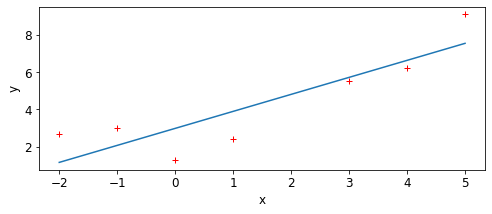

In [ ]:
plot_points_and_y(points, vx, oy)


## Exercises

Using the method illustrated above, fit the following equations to our set of points.  Use `vx`, `xy` for $x$, $y$, and `va`, `vb`, `vc`, etc for the parameters.  This is important, or the tests won't pass.

$$
y = a^x + bx + c
$$

## Conclusion

Congratulations, you have now implemented the core of [PyTorch](https://pytorch.org)!  Pytorch is build on the ability to write expressions, of which the gradient is computed and automatically propagated; the core constructs, such as `zero_gradient`, `compute_gradient`, and `compute`, are essentially similar.  It is true; Pytorch does add a few things:

* Ability to deal with $n$-dimensional tensors, to represent vectors of inputs and outputs. 
* Optimized backends, using both parallelism and GPUs. 
* Sophisticated mechanisms to deal with large datasets.
* A wide array of operations available on tensors, of which autograd can be computed. 
* Many implemented heuristics to deal with step size.
* Implemented neural layers (sigmoids, ReLU, etc).
* Convolutional nets for images.
* Recurrent nets and LSTMs of streams of data.

And more! But [aside from tensors, backends, GPUs, parallelism, operations, heuristics, neural layers including convolutions and LSTMs, and good output](https://www.youtube.com/watch?v=Y7tvauOJMHo), PyTorch is really nothing more than what you have already implemented.